In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline
from CosmologyModel import *
from CovarianceMatrix import *
from InitializeVariables import *
from VarianceCalculator import *
from FilterFunctions import *
from CommonUtils import *
from CriticalPoints import *
from ComputePDF import *
from LoadSimulations import *

import cProfile, pstats

In [2]:
cosmotable = np.loadtxt('/feynman/work/dap/lcs/vt272285/final_codes/LDT_2cell_l1_norm/data/CosmoTable.dat')
cosmotable_om = cosmotable[:,1]
cosmotable_h = cosmotable[:,2]
cosmotable_w0 = cosmotable[:,3]
cosmotable_sig8 =  cosmotable[:,4]
cosmotable_oc = cosmotable[:,5]

# Define parameter bounds based on min and max values
param_bounds = np.array([
    [np.min(cosmotable_om), cosmotable_om.max()],
    [cosmotable_h.min(), cosmotable_h.max()],
    [cosmotable_w0.min(), cosmotable_w0.max()],
    [cosmotable_sig8.min(), cosmotable_sig8.max()],
    [cosmotable_oc.min(), cosmotable_oc.max()]
])

lh_df = pd.DataFrame(cosmotable[:,1:], columns=["Om", "h", "w0", "sig8", "Oc"])

cosmotable_new = np.loadtxt('/feynman/work/dap/lcs/vt272285/final_codes/LDT_2cell_l1_norm/data/lhs_cosmo_samples_halofit.dat')
cosmotable_om_new = cosmotable_new[:,0]
cosmotable_h_new = cosmotable_new[:,1]
cosmotable_w0_new = cosmotable_new[:,2]
cosmotable_sig8_new =  cosmotable_new[:,3]
# cosmotable_oc = cosmotable[:,5]


lh_df_new = pd.DataFrame(cosmotable_new[:,:], columns=["Om", "h", "w0", "sig8"])

# print(lh_df.T)

In [60]:
theta = 20
R_pixels = theta/0.5

edges = np.linspace(-0.04,0.04,402)
centers = 0.5*(edges[1:] + edges[:-1])
snr = np.linspace(-4,4,401)

tomo_bin = 5
filter_type = 'tophat'

covs = []
for cosmo_index in range(0,25):
    sim_l1_runs, sim_pdf_runs, avg_sim_l1, std_sim_l1, avg_sim_pdf, std_sim_pdf, simvar = get_simulation_l1(
                                                                                            cosmo_index,
                                                                                            tomo_bin,
                                                                                            edges,
                                                                                            centers,
                                                                                            snr,
                                                                                            R_pixels=R_pixels,
                                                                                            filter_type=filter_type,
                                                                                            plot=False,
                                                                                        )

    cov = np.cov(sim_pdf_runs, rowvar=False)
    covs.append(cov)
    



(25, 401, 401)

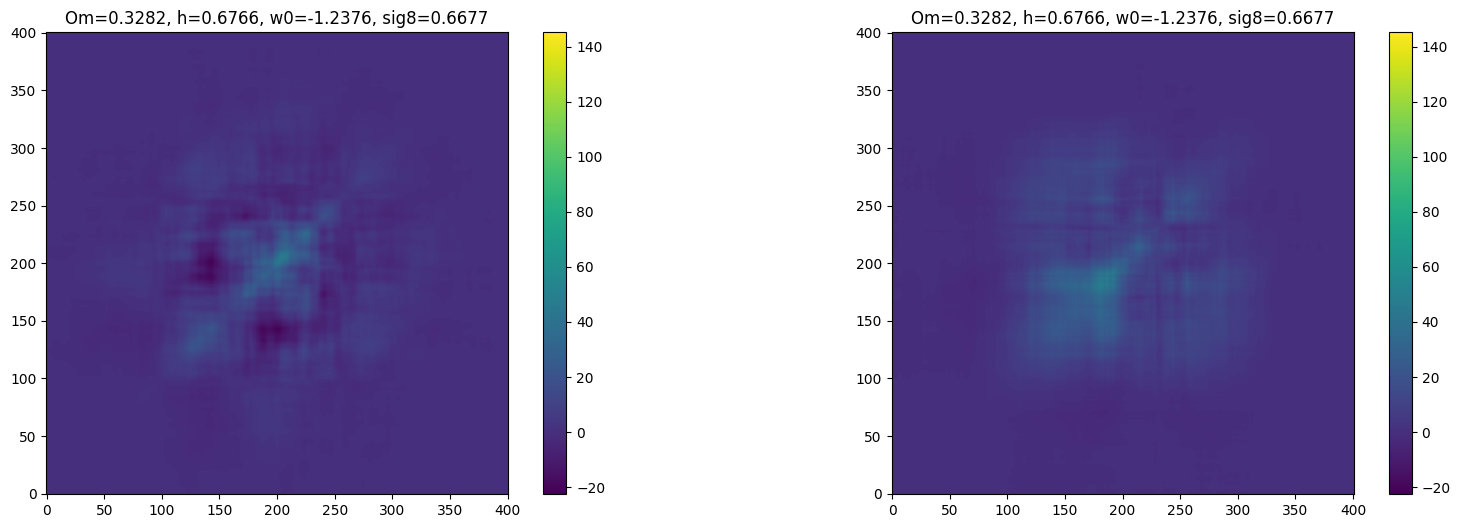

In [61]:
covs = np.array(covs)
plt.figure(figsize=(20, 6))
vmin = np.min(covs)
vmax = np.max(covs)
plt.subplot(1, 2, 1)
plt.imshow(covs[0], cmap='viridis', interpolation='nearest', origin='lower', vmin=vmin, vmax=vmax)
plt.title(f"Om={lh_df.iloc[0]['Om']}, h={lh_df.iloc[0]['h']}, w0={lh_df.iloc[0]['w0']}, sig8={lh_df.iloc[0]['sig8']}")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(covs[1], cmap='viridis', interpolation='nearest', origin='lower', vmin=vmin, vmax=vmax)
plt.title(f"Om={lh_df.iloc[0]['Om']}, h={lh_df.iloc[0]['h']}, w0={lh_df.iloc[0]['w0']}, sig8={lh_df.iloc[0]['sig8']}")
plt.colorbar()
covs.shape

In [55]:
# covs has shape (25, B, B)
B = covs.shape[1]
cov_flat = covs.reshape(25, B*B)   # now shape (25, features)

param_names = ["Ωₘ","h","w₀","σ₈","Ω_c"]
params = np.vstack([cosmotable_om[:-1],
                    cosmotable_h[:-1],
                    cosmotable_w0[:-1],
                    cosmotable_sig8[:-1],
                    cosmotable_oc[:-1]]).T

ndim = len(param_names)

# 1) compute full corr_maps
# corrs = np.zeros((B*B, ndim))
# for ip in range(ndim):
#     for k in range(B*B):
#         corrs[k, ip] = pearsonr(cov_flat[:,k], params[:,ip])[0]
# corr_maps = corrs.reshape(B, B, ndim)

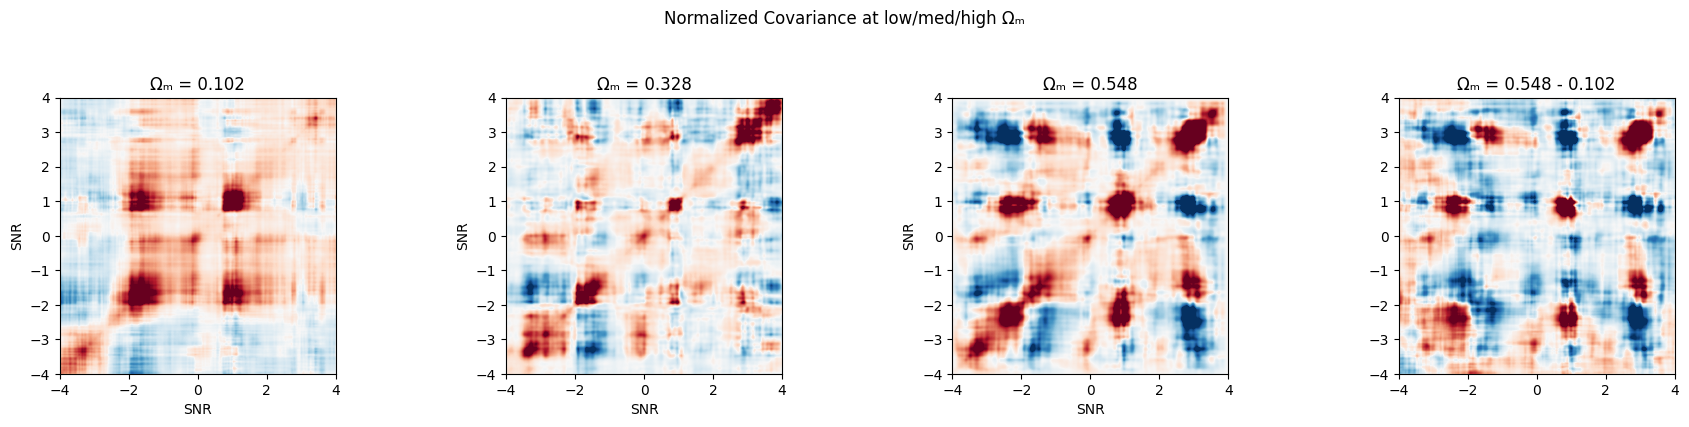

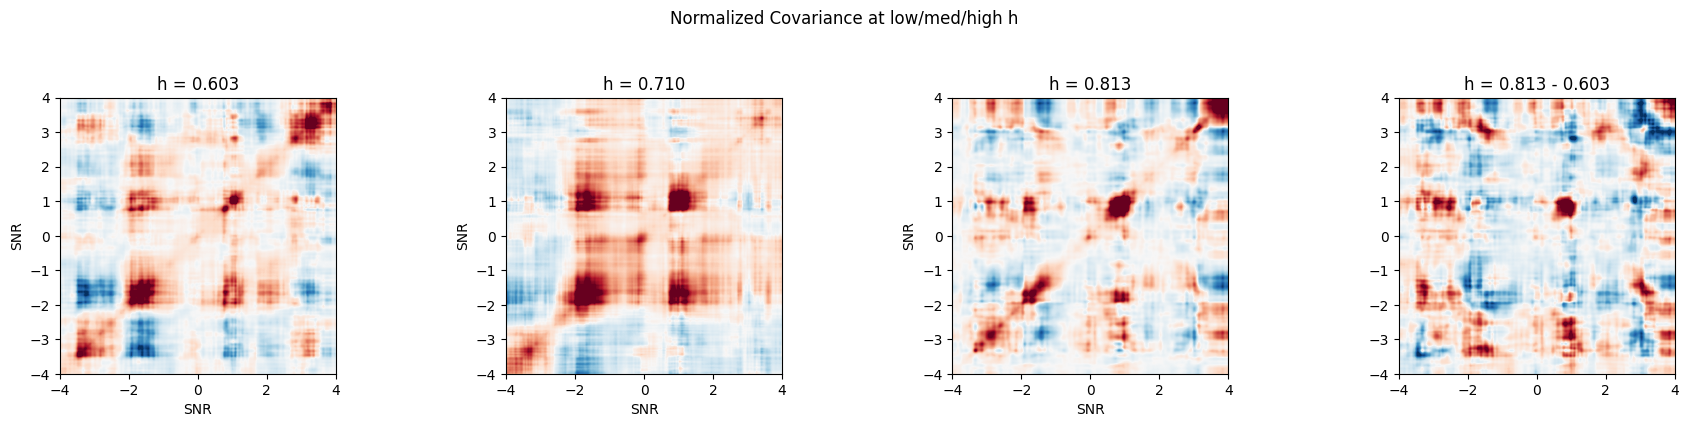

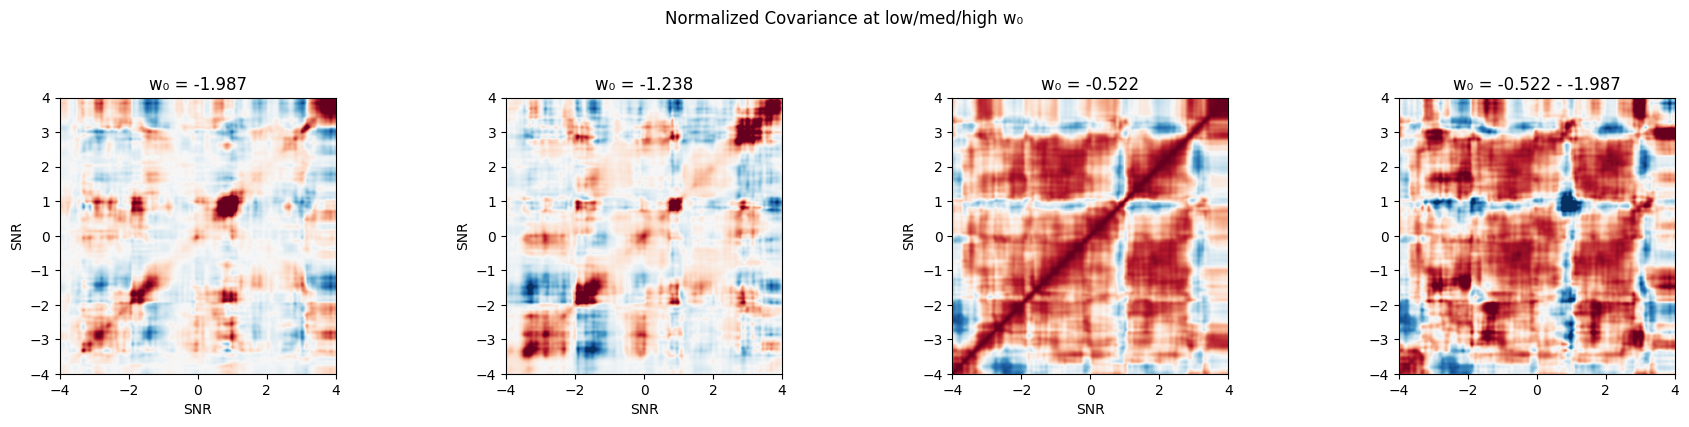

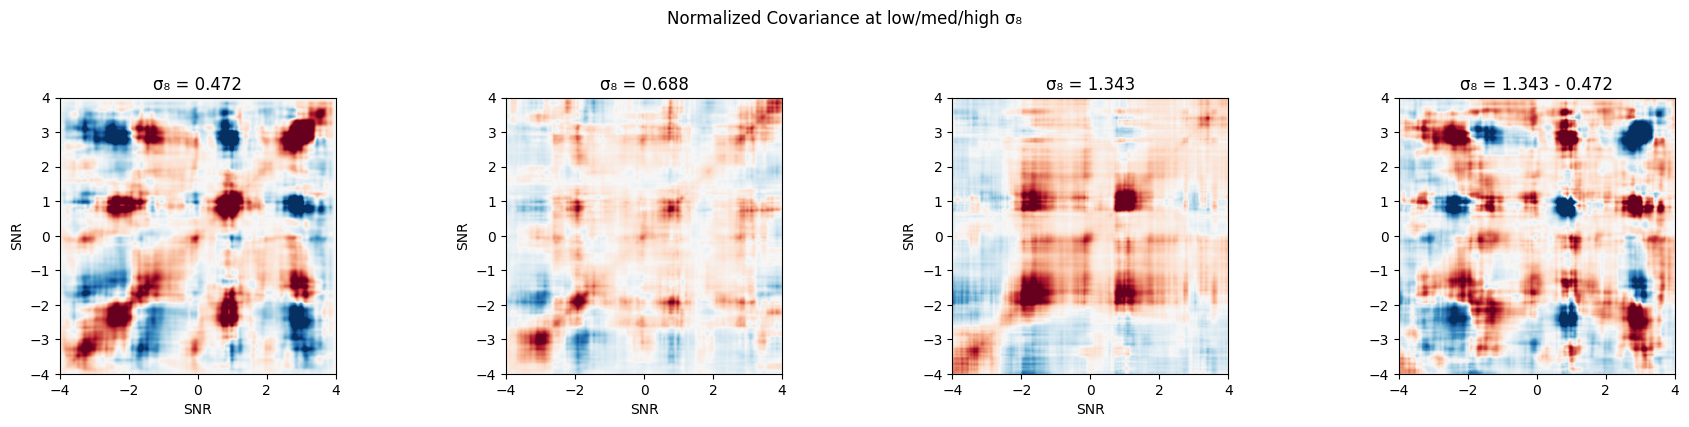

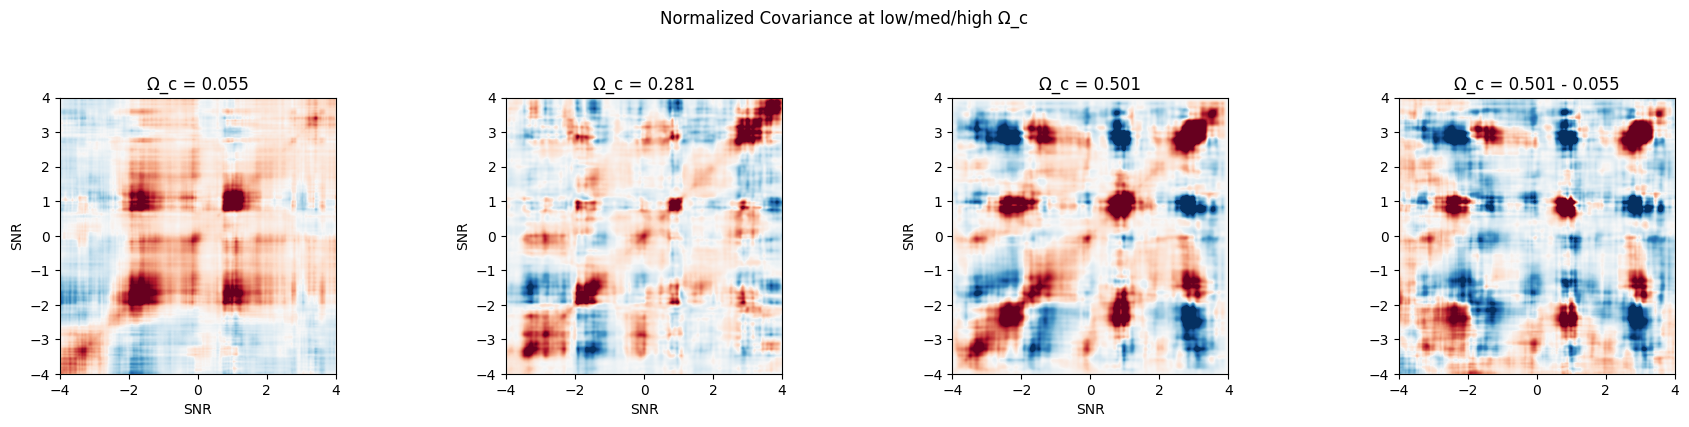

In [62]:
# (a) pick the reference cosmology Nmax as the one with max total variance
diag_sums = np.sum(np.diagonal(covs, axis1=1, axis2=2), axis=1)  # (25,)
nmax      = np.argmax(diag_sums)

# (b) reference diagonal
ref_diag  = np.diagonal(covs[nmax], axis1=0, axis2=1)           # (B,)

# (c) normalized covariances
#     shape: (25, B, B)
C_norm    = covs / np.sqrt(ref_diag[None,:,None] * ref_diag[None,None,:])

# --- 2) Plot heatmaps at low/med/high of each parameter ---
param_names = ["Ωₘ","h","w₀","σ₈","Ω_c"]
# assume params has shape (25,5) in the same order

for ip, name in enumerate(param_names):
    # sort cosmologies by the ip-th parameter
    order = np.argsort(params[:,ip])
    picks = [order[0],                # lowest
             order[len(order)//2],    # median
             order[-1]]               # highest

    fig, axes = plt.subplots(1, 4, figsize=(18,4), tight_layout=True)
    for ax, idx in zip(axes, picks):
        im = ax.imshow(C_norm[idx], origin='lower', vmin=-1, vmax=+1, cmap='RdBu_r',extent=[snr[0],snr[-1], snr[0],snr[-1]])
        ax.set_title(f"{name} = {params[idx,ip]:.3f}")
        ax.set_xlabel("SNR")
        ax.set_ylabel("SNR")
   
    im = axes[3].imshow(C_norm[picks[-1]]-C_norm[picks[0]], origin='lower', vmin=-1, vmax=+1, cmap='RdBu_r',extent=[snr[0],snr[-1], snr[0],snr[-1]])
    axes[3].set_title(f"{name} = {params[picks[-1],ip]:.3f} - {params[picks[0],ip]:.3f}") 
    fig.suptitle(f"Normalized Covariance at low/med/high {name}", y=1.05)
    plt.show()
    


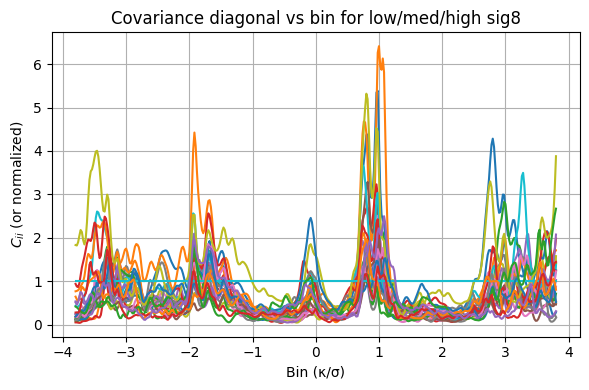

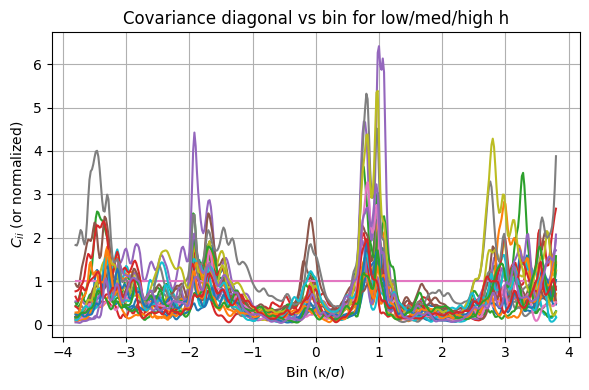

In [64]:
bins = snr         # length B

# choose which parameter to sweep
ip, name = 3, "sig8"  

# sort cosmologies by this parameter and pick low/med/high
order = np.argsort(params[:,ip])
picks = [order[0], order[len(order)//2], order[-1]]

fig, ax = plt.subplots(figsize=(6,4))

for idx in order:
    # choose raw or normalized diagonal:
    diag = C_norm[idx].diagonal()   
    # or for raw: diag = covs[idx].diagonal()

    ax.plot(bins[10:-10], diag[10:-10], linestyle='-',
            label=f"{name} = {params[idx,ip]:.3f}")

ax.set_xlabel("Bin (κ/σ)")
ax.set_ylabel(r"$C_{ii}$" + " (or normalized)" )
ax.set_title("Covariance diagonal vs bin for low/med/high " + name)
# ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


ip, name = 1, "h"   # or ip=1, name="h"

# sort cosmologies by this parameter and pick low/med/high
order = np.argsort(params[:,ip])
picks = [order[0], order[len(order)//2], order[-1]]

fig, ax = plt.subplots(figsize=(6,4))

for idx in order:
    # choose raw or normalized diagonal:
    diag = C_norm[idx].diagonal()   
    # or for raw: diag = covs[idx].diagonal()

    ax.plot(bins[10:-10], diag[10:-10], linestyle='-',
            label=f"{name} = {params[idx,ip]:.3f}")

ax.set_xlabel("Bin (κ/σ)")
ax.set_ylabel(r"$C_{ii}$" + " (or normalized)" )
ax.set_title("Covariance diagonal vs bin for low/med/high " + name)
# ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()